# PredatorPrey10x10-P4-p3-s3-coop-v0 Experiment analysis

In [43]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

ENV_NAME = "PredatorPrey10x10-P4-p3-s3-coop-v0"
baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", ENV_NAME, "results", "sp_exp_seed0_v0.csv"
)
figure_dir = osp.join(BASE_REPO_DIR, "experiments", ENV_NAME, "figures")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "predatorprey10x10_P4_p3_s3_coop_v0", "results", "pairwise_results.csv"
)

## Define Co-Player Prior

In [44]:
# Uniform Prior over each self-play team of agents (minus Planning agent with default agent id 0)
policy_prior = {
    (-1, 'sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'): 0.2,
    (-1, 'sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'): 0.2,
    (-1, 'sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'): 0.2,
    (-1, 'sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'): 0.2,
    (-1, 'sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'): 0.2,
}
coteam_policy_prior = {
    ('sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'): 0.2,
    ('sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'): 0.2,
    ('sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'): 0.2,
    ('sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'): 0.2,
    ('sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'): 0.2,
}

fixed_policy_ids = [
    'sp_seed0-v0',
    'sp_seed1-v0',
    'sp_seed2-v0',
    'sp_seed3-v0',
    'sp_seed4-v0'
]
fixed_team_ids = [
    ('sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'),
    ('sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'),
    ('sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'),
    ('sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'),
    ('sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'),
]

fixed_co_team_ids = [
    ('sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'),
    ('sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'),
    ('sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'),
    ('sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'),
    ('sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'),
]

fixed_policy_and_coteam_label_map = {
    'sp_seed0-v0': "S0",
    'sp_seed1-v0': "S1",
    'sp_seed2-v0': "S2",
    'sp_seed3-v0': "S3",
    'sp_seed4-v0': "S4",
    ('sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'): "T0",
    ('sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'): "T1",
    ('sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'): "T2",
    ('sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'): "T3",
    ('sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'): "T4",
}

# Problem size

**States**

```
= pos^(num_predators + num_prey) * caught^num_prey 

= (10*10)^(4+3) * 2^3    
= 8×10^14
```

Note, this is a slight overestimate since since agents cannot be in the same pos at the same time. 
But you get the idea.

**Actions** = 5 (do_nothing, up, down,  left, right)

**Observations** = 2 cells in each direction = 5x5 grid

## The Environment

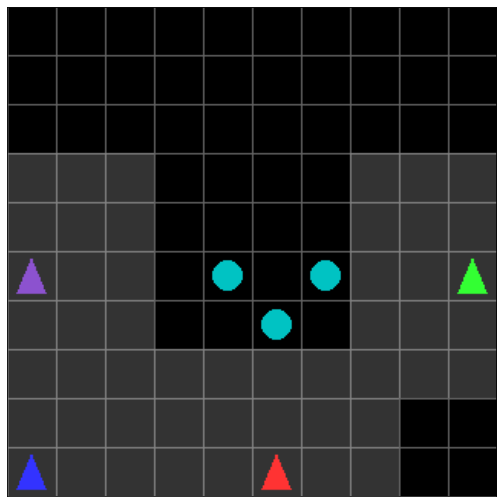

In [45]:
fig, ax = plot_utils.plot_environment(ENV_NAME, (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Heuristic Policy Data

In [46]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_agent_ids = policy_df["agent_id"].unique().tolist()
policy_agent_ids.sort()
print(f"Agent IDs = {policy_agent_ids}")

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("\nAll Policies")
print("------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)

#  Add team column
# def get_team_id(row):
#     pi_ids = [row[f"coplayer_policy_id_{i}"] for i in policy_agent_ids]
#     pi_ids.sort()
#     return tuple(pi_ids)

# policy_df["team_id"] = policy_df.apply(get_team_id, axis=1)
# all_team_ids = policy_df["team_id"].unique().tolist()
# all_team_ids.sort()
# print("\nAll Team IDs")
# print("--------")
# for t_id in all_team_ids:
#     print(f"    {t_id}")

# Add Co-Team Column
def get_co_team_id(row):
    pi_ids = [row[f"coplayer_policy_id_{i}"] for i in policy_agent_ids if i != row["agent_id"]]
    pi_ids.sort()
    return tuple(pi_ids)
    
policy_df["co_team_id"] = policy_df.apply(get_co_team_id, axis=1)
all_co_team_ids = policy_df["co_team_id"].unique().tolist()
all_co_team_ids.sort()
print("\nAll Co-Team IDs")
print("---------------")
for t_id in all_co_team_ids:
    print(f"    {t_id}")
    
# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]
kept_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
kept_fixed_policy_ids.sort()
print("\nFixed Policies")
print("--------------")
for pi_id in kept_fixed_policy_ids:
    print("  ", pi_id)
    
# Drop unneeded co-teams
policy_df = policy_df[policy_df["co_team_id"].isin(fixed_co_team_ids)]
kept_co_team_ids = policy_df["co_team_id"].unique().tolist()
kept_co_team_ids.sort()
print("\nCo-Team IDs")
print("-----------")
for t_id in kept_co_team_ids:
    print(f"    {t_id}")

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

Agent IDs = [0, 1, 2, 3]

All Policies
------------
   random-v0
   sp_seed0-v0
   sp_seed1-v0
   sp_seed2-v0
   sp_seed3-v0
   sp_seed4-v0

All Co-Team IDs
---------------
    ('random-v0', 'random-v0', 'random-v0')
    ('random-v0', 'random-v0', 'sp_seed0-v0')
    ('random-v0', 'random-v0', 'sp_seed1-v0')
    ('random-v0', 'random-v0', 'sp_seed2-v0')
    ('random-v0', 'random-v0', 'sp_seed3-v0')
    ('random-v0', 'random-v0', 'sp_seed4-v0')
    ('random-v0', 'sp_seed0-v0', 'sp_seed0-v0')
    ('random-v0', 'sp_seed0-v0', 'sp_seed1-v0')
    ('random-v0', 'sp_seed0-v0', 'sp_seed2-v0')
    ('random-v0', 'sp_seed0-v0', 'sp_seed3-v0')
    ('random-v0', 'sp_seed0-v0', 'sp_seed4-v0')
    ('random-v0', 'sp_seed1-v0', 'sp_seed1-v0')
    ('random-v0', 'sp_seed1-v0', 'sp_seed2-v0')
    ('random-v0', 'sp_seed1-v0', 'sp_seed3-v0')
    ('random-v0', 'sp_seed1-v0', 'sp_seed4-v0')
    ('random-v0', 'sp_seed2-v0', 'sp_seed2-v0')
    ('random-v0', 'sp_seed2-v0', 'sp_seed3-v0')
    ('random-v0', 'sp_see

## Fixed policy pairwise performance

This is what was used to generate the meta-policies.

Here we show pairwise performance between each individual policy and co-team

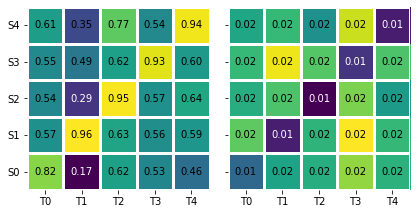

In [47]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    coplayer_policy_key="co_team_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_co_team_ids,
    policy_labels=fixed_policy_and_coteam_label_map,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoffs.png"))

In [48]:
# Get payofss in meta policy dictionary format (for use in experiments)
pw_values, (row_policies, col_teams) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    coplayer_policy_key="co_team_id",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_co_team_ids,
    average_duplicates=True,
    duplicate_warning=True
)

for c, col_team in enumerate(col_teams):
    team_str = '", "'.join(col_team)
    print(f'(-1, "{team_str}"):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")

(-1, "sp_seed0-v0", "sp_seed0-v0", "sp_seed0-v0"): {
    "sp_seed0-v0": 0.82,
    "sp_seed1-v0": 0.57,
    "sp_seed2-v0": 0.54,
    "sp_seed3-v0": 0.55,
    "sp_seed4-v0": 0.61,
},
(-1, "sp_seed1-v0", "sp_seed1-v0", "sp_seed1-v0"): {
    "sp_seed0-v0": 0.17,
    "sp_seed1-v0": 0.96,
    "sp_seed2-v0": 0.29,
    "sp_seed3-v0": 0.49,
    "sp_seed4-v0": 0.35,
},
(-1, "sp_seed2-v0", "sp_seed2-v0", "sp_seed2-v0"): {
    "sp_seed0-v0": 0.62,
    "sp_seed1-v0": 0.63,
    "sp_seed2-v0": 0.95,
    "sp_seed3-v0": 0.62,
    "sp_seed4-v0": 0.77,
},
(-1, "sp_seed3-v0", "sp_seed3-v0", "sp_seed3-v0"): {
    "sp_seed0-v0": 0.53,
    "sp_seed1-v0": 0.56,
    "sp_seed2-v0": 0.57,
    "sp_seed3-v0": 0.93,
    "sp_seed4-v0": 0.54,
},
(-1, "sp_seed4-v0", "sp_seed4-v0", "sp_seed4-v0"): {
    "sp_seed0-v0": 0.46,
    "sp_seed1-v0": 0.59,
    "sp_seed2-v0": 0.64,
    "sp_seed3-v0": 0.60,
    "sp_seed4-v0": 0.94,
},


## Add Full-Knowledge Best-Response baseline

In [49]:
# Maps from Co-Team ID to best fixed policy
best_response_map = {
    ('sp_seed0-v0', 'sp_seed0-v0', 'sp_seed0-v0'): 'sp_seed0-v0',
    ('sp_seed1-v0', 'sp_seed1-v0', 'sp_seed1-v0'): 'sp_seed1-v0',
    ('sp_seed2-v0', 'sp_seed2-v0', 'sp_seed2-v0'): 'sp_seed2-v0',
    ('sp_seed3-v0', 'sp_seed3-v0', 'sp_seed3-v0'): 'sp_seed3-v0',
    ('sp_seed4-v0', 'sp_seed4-v0', 'sp_seed4-v0'): 'sp_seed4-v0',
}

# use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
br_agent_id = 0

new_rows = []
for co_team_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    
    # Add BR agent row
    br_row = policy_df.loc[
        (policy_df["agent_id"] == br_agent_id)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["co_team_id"] == co_team_id)
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    old_exp_id = br_row["exp_id"]
    br_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    
    # Add Coplayer rows from same exp_id
    for co_agent_id in policy_agent_ids:
        if co_agent_id == br_agent_id:
            continue
        br_coplayer_row = policy_df.loc[
            (policy_df["agent_id"] == co_agent_id)
            & (policy_df["exp_id"].isin(old_exp_id))
        ].copy()
        br_coplayer_row["exp_id"] = next_exp_id
        new_rows.append(br_coplayer_row)

print(f"{len(policy_df)=}")
print(f"{len(new_rows)=}")
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(f"{len(br_df)=}")
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(f"{len(policy_br_df)=} (i.e. all together)")
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

len(policy_df)=40
len(new_rows)=20
len(br_df)=20
len(policy_br_df)=60 (i.e. all together)


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,time_limit,episode_return_mean,episode_return_std,episode_return_max,...,prop_DRAW,prop_WIN,prop_NA,num_sims,truncated,coplayer_policy_id_0,coplayer_policy_id_1,coplayer_policy_id_2,coplayer_policy_id_3,co_team_id
40,126,0,PredatorPrey10x10-P4-p3-s3-coop-v0,full-knowledge-br,0,1000,None,0.820000,0.216641,1.0,...,0.0,0.543,0.457,0,False,sp_seed0-v0,sp_seed0-v0,sp_seed0-v0,sp_seed0-v0,"(sp_seed0-v0, sp_seed0-v0, sp_seed0-v0)"
44,126,0,PredatorPrey10x10-P4-p3-s3-coop-v0,full-knowledge-br,0,1000,None,0.961333,0.150755,1.0,...,0.0,0.924,0.076,0,False,sp_seed1-v0,sp_seed1-v0,sp_seed1-v0,sp_seed1-v0,"(sp_seed1-v0, sp_seed1-v0, sp_seed1-v0)"
48,126,0,PredatorPrey10x10-P4-p3-s3-coop-v0,full-knowledge-br,0,1000,None,0.953667,0.128961,1.0,...,0.0,0.874,0.126,0,False,sp_seed2-v0,sp_seed2-v0,sp_seed2-v0,sp_seed2-v0,"(sp_seed2-v0, sp_seed2-v0, sp_seed2-v0)"
52,126,0,PredatorPrey10x10-P4-p3-s3-coop-v0,full-knowledge-br,0,1000,None,0.926333,0.168047,1.0,...,0.0,0.816,0.184,0,False,sp_seed3-v0,sp_seed3-v0,sp_seed3-v0,sp_seed3-v0,"(sp_seed3-v0, sp_seed3-v0, sp_seed3-v0)"
56,126,0,PredatorPrey10x10-P4-p3-s3-coop-v0,full-knowledge-br,0,1000,None,0.944000,0.149732,1.0,...,0.0,0.856,0.144,0,False,sp_seed4-v0,sp_seed4-v0,sp_seed4-v0,sp_seed4-v0,"(sp_seed4-v0, sp_seed4-v0, sp_seed4-v0)"


## Loading BAPOSGMCP Data

In [50]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

print("Agent IDs:", baposgmcp_df["agent_id"].unique())

# Add Co-Team Column
baposgmcp_df["co_team_id"] = baposgmcp_df.apply(get_co_team_id, axis=1)
baposgmcp_coteam_ids = baposgmcp_df["co_team_id"].unique().tolist()
baposgmcp_coteam_ids.sort()
print("\nCo-Team IDs")
print("---------------")
for t_id in baposgmcp_coteam_ids:
    print(f"    {t_id}")

policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/utils.py:171: DtypeWarning: Columns (11,12,13,16,17,19,20,21,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(result_file)


Agent IDs: [0 1 2 3]

Co-Team IDs
---------------
    ('POMetaRollout_greedy_numsims10', 'sp_seed0-v0', 'sp_seed0-v0')
    ('POMetaRollout_greedy_numsims10', 'sp_seed1-v0', 'sp_seed1-v0')
    ('POMetaRollout_greedy_numsims10', 'sp_seed2-v0', 'sp_seed2-v0')
    ('POMetaRollout_greedy_numsims10', 'sp_seed3-v0', 'sp_seed3-v0')
    ('POMetaRollout_greedy_numsims10', 'sp_seed4-v0', 'sp_seed4-v0')
    ('POMetaRollout_greedy_numsims100', 'sp_seed0-v0', 'sp_seed0-v0')
    ('POMetaRollout_greedy_numsims100', 'sp_seed1-v0', 'sp_seed1-v0')
    ('POMetaRollout_greedy_numsims100', 'sp_seed2-v0', 'sp_seed2-v0')
    ('POMetaRollout_greedy_numsims100', 'sp_seed3-v0', 'sp_seed3-v0')
    ('POMetaRollout_greedy_numsims100', 'sp_seed4-v0', 'sp_seed4-v0')
    ('POMetaRollout_greedy_numsims1000', 'sp_seed0-v0', 'sp_seed0-v0')
    ('POMetaRollout_greedy_numsims1000', 'sp_seed1-v0', 'sp_seed1-v0')
    ('POMetaRollout_greedy_numsims1000', 'sp_seed2-v0', 'sp_seed2-v0')
    ('POMetaRollout_greedy_numsims1000', '

## Combine data

In [51]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)

def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("sp_seed"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "pisp"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in combined_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_numsims10
   POMetaRollout_greedy_numsims100
   POMetaRollout_greedy_numsims1000
   POMetaRollout_greedy_numsims50
   POMetaRollout_greedy_numsims500
   POMetaRollout_softmax_numsims10
   POMetaRollout_softmax_numsims100
   POMetaRollout_softmax_numsims1000
   POMetaRollout_softmax_numsims50
   POMetaRollout_softmax_numsims500
   POMetaRollout_uniform_numsims10
   POMetaRollout_uniform_numsims100
   POMetaRollout_uniform_numsims1000
   POMetaRollout_uniform_numsims50
   POMetaRollout_uniform_numsims500
   POMeta_greedy_numsims10
   POMeta_greedy_numsims100
   POMeta_greedy_numsims1000
   POMeta_greedy_numsims50
   POMeta_greedy_numsims500
   POMeta_softmax_numsims10
   POMeta_softmax_numsims100
   POMeta_softmax_numsims1000
   POMeta_softmax_numsims50
   POMeta_softmax_numsims500
   POMeta_uniform_numsims10
   POMeta_uniform_numsims100
   POMeta_uniform_numsims1000
   POMeta_uniform_numsims50
   POMeta_uniform_numsims500
   baposgmcp_fixed_pisp

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

(<Figure size 1440x6048 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

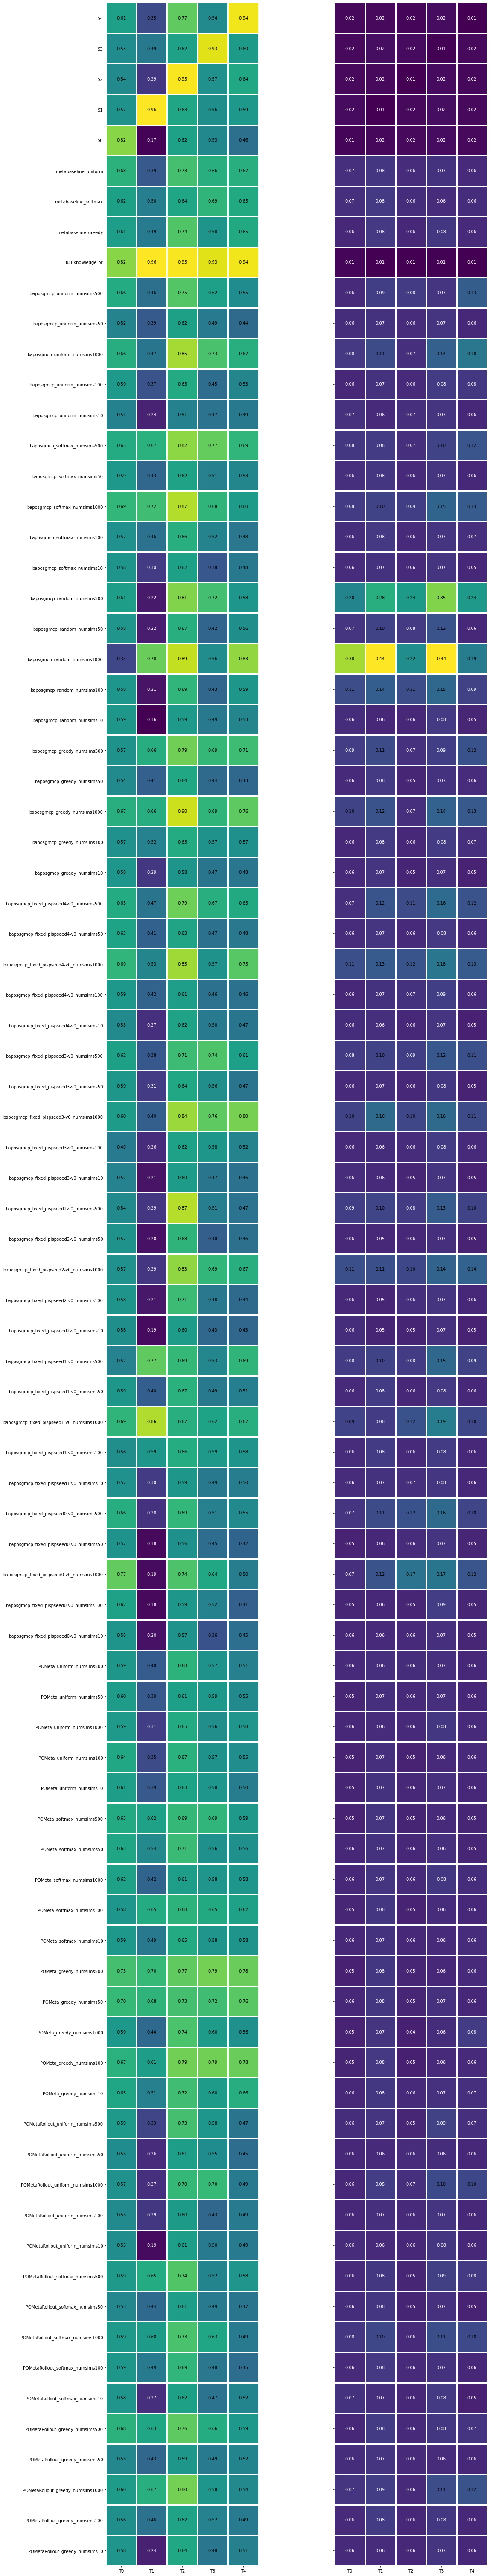

In [52]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    coplayer_policy_key="co_team_id",
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=fixed_co_team_ids,
    policy_labels=fixed_policy_and_coteam_label_map,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1440x6048 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

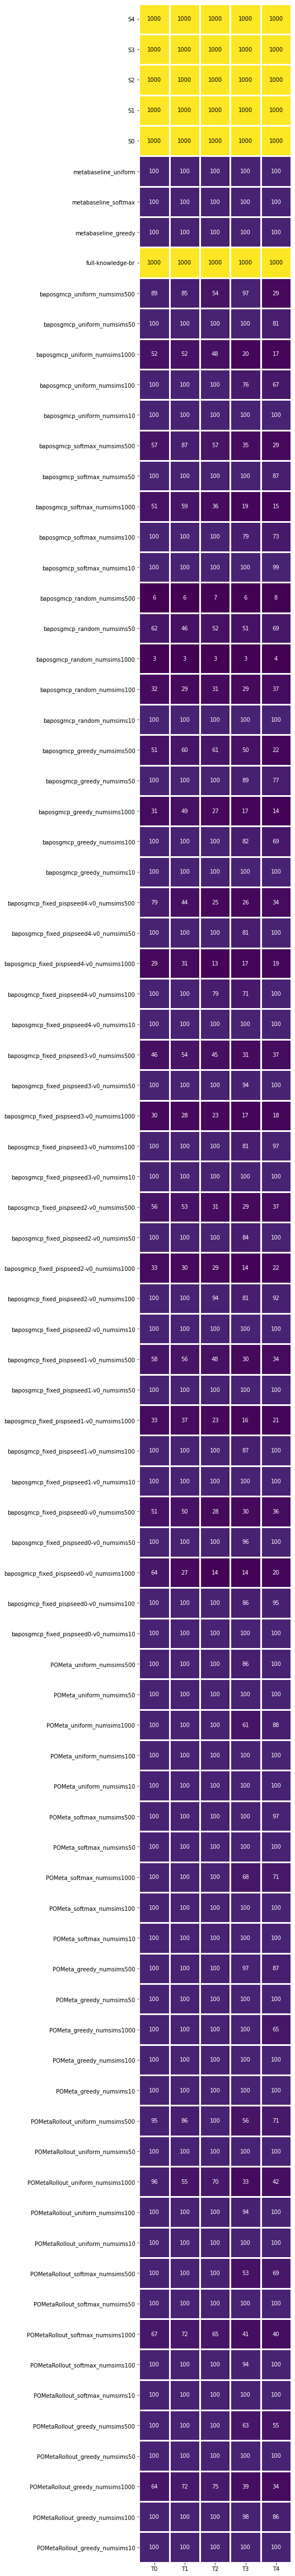

In [53]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    coplayer_policy_key="co_team_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.0f}",
    coplayer_policies=fixed_co_team_ids,
    policy_labels=fixed_policy_and_coteam_label_map,
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [54]:
exp_df = plot_utils.get_uniform_expected_df(combined_df, coteam_policy_prior, "co_team_id")

Ungrouped size = 450
Grouped size = 84


In [55]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

### Action Selection

In [56]:
exp_df["action_selection"].unique()

array(['pucb', None], dtype=object)

### Comparison of truncation

In [57]:
exp_df["truncated"].unique()

array([ True, False])

### Comparison of the different Meta-Policies

In [58]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta", "metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
metabaseline

Policy IDs
----------
POMetaRollout_greedy_numsims10
POMetaRollout_greedy_numsims100
POMetaRollout_greedy_numsims1000
POMetaRollout_greedy_numsims50
POMetaRollout_greedy_numsims500
POMetaRollout_softmax_numsims10
POMetaRollout_softmax_numsims100
POMetaRollout_softmax_numsims1000
POMetaRollout_softmax_numsims50
POMetaRollout_softmax_numsims500
POMetaRollout_uniform_numsims10
POMetaRollout_uniform_numsims100
POMetaRollout_uniform_numsims1000
POMetaRollout_uniform_numsims50
POMetaRollout_uniform_numsims500
POMeta_greedy_numsims10
POMeta_greedy_numsims100
POMeta_greedy_numsims1000
POMeta_greedy_numsims50
POMeta_greedy_numsims500
POMeta_softmax_numsims10
POMeta_softmax_numsims100
POMeta_softmax_numsims1000
POMeta_softmax_numsims50
POMeta_softmax_numsims500
POMeta_uniform_numsims10
POMeta_uniform_numsims100
POMeta_uniform_numsims1000
POMeta_uniform_numsims50
POMeta_uniform_numsims500
baposgmcp_greedy_numsims10
baposgmcp_greedy_nums

POMeta
POMetaRollout
baposgmcp
metabaseline


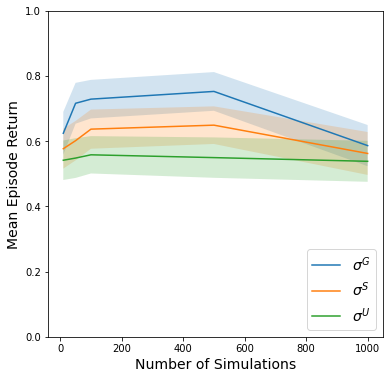

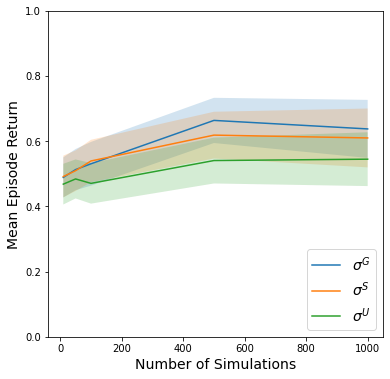

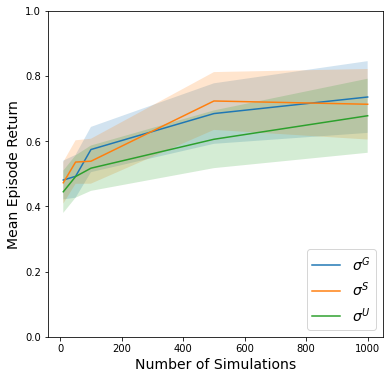

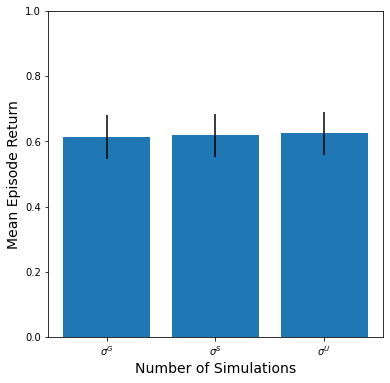

In [60]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp
metabaseline


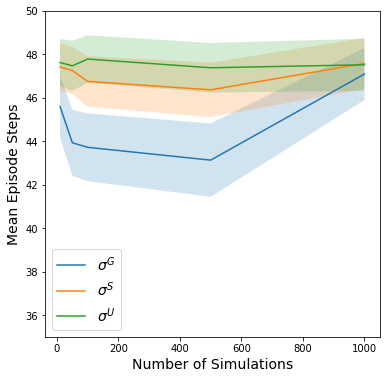

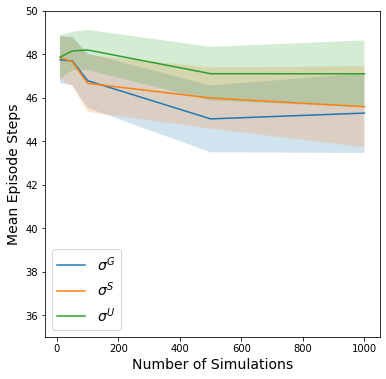

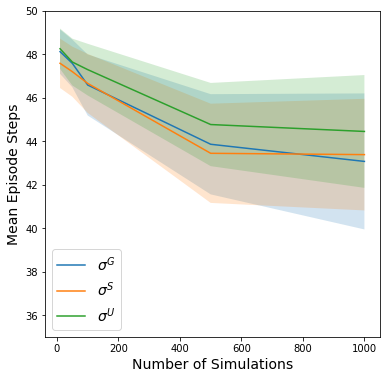

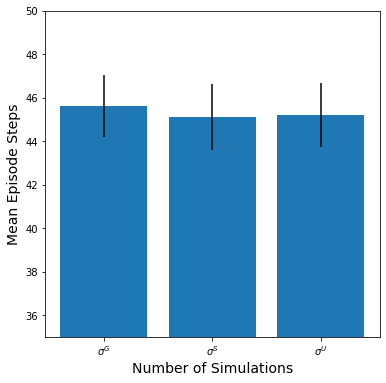

In [61]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (35, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'lower left',
    # "title": "Meta-Policy",  
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_step_{alg_id}.png"))
    
del plot_kwargs

### Comparing Meta-Policy versus no meta-policy

Here we look at the performance of BAPOSGMCP (using PUCB) with using a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

In [62]:
meta_vs_no_pi_label_map = {
    "baposgmcp_softmax": r"$\sigma^{S}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_pispseed0-v0": "S0", 
    "baposgmcp_fixed_pispseed1-v0": "S1", 
    "baposgmcp_fixed_pispseed2-v0": "S2",
    "baposgmcp_fixed_pispseed3-v0": "S3",
    "baposgmcp_fixed_pispseed4-v0": "S4"
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random"]))
    # (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        (exp_df["alg_id"] == "baposgmcp_random") | (exp_df["truncated"] == True)
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
baposgmcp_fixed_pispseed0-v0_numsims10
baposgmcp_fixed_pispseed0-v0_numsims100
baposgmcp_fixed_pispseed0-v0_numsims1000
baposgmcp_fixed_pispseed0-v0_numsims50
baposgmcp_fixed_pispseed0-v0_numsims500
baposgmcp_fixed_pispseed1-v0_numsims10
baposgmcp_fixed_pispseed1-v0_numsims100
baposgmcp_fixed_pispseed1-v0_numsims1000
baposgmcp_fixed_pispseed1-v0_numsims50
baposgmcp_fixed_pispseed1-v0_numsims500
baposgmcp_fixed_pispseed2-v0_numsims10
baposgmcp_fixed_pispseed2-v0_numsims100
baposgmcp_fixed_pispseed2-v0_numsims1000
baposgmcp_fixed_pispseed2-v0_numsims50
baposgmcp_fixed_pispseed2-v0_numsims500
baposgmcp_fixed_pispseed3-v0_numsims10
baposgmcp_fixed_pispseed3-v0_numsims100
baposgmcp_fixed_pispseed3-v0_numsims1000
baposgmcp_fixed_pispseed3-v0_numsims50
baposgmcp_fixed_pispseed3-v0_numsims500
baposgmcp_fixed_pispseed4-v0_numsims10
baposgmcp_fixed_pispseed4-v0_numsims100
baposgmcp_fixed_pispseed4-v0_numsims1000
ba

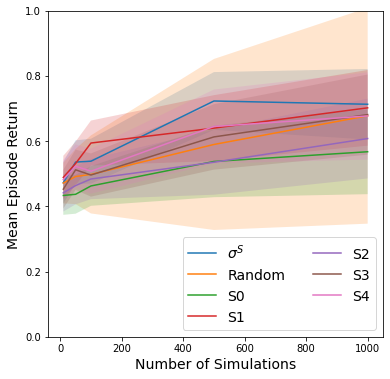

In [70]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 2
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return.png"))
    
del plot_kwargs

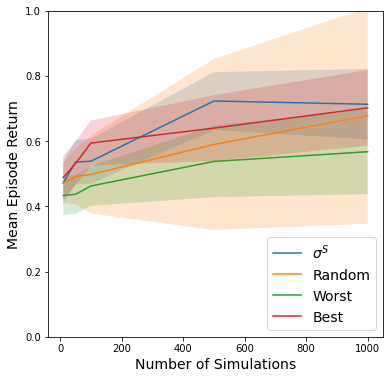

In [74]:
# TODO May need to change this with more results
meta_vs_no_best_and_worst_pi_label_map = {
    "baposgmcp_softmax": r"$\sigma^{S}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_pispseed0-v0": "Worst", 
    "baposgmcp_fixed_pispseed1-v0": "Best", 
    # "baposgmcp_fixed_pispseed2-v0": "S2",
    # "baposgmcp_fixed_pispseed3-v0": "S3",
    # "baposgmcp_fixed_pispseed4-v0": "S4"
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map)],
    pi_label_map=meta_vs_no_best_and_worst_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst.png"))
    
del plot_kwargs

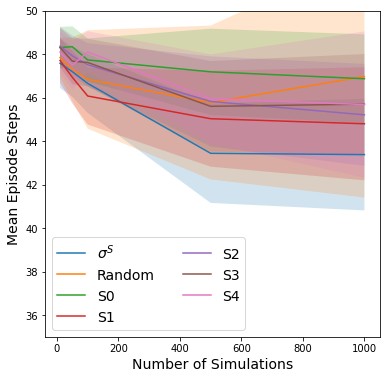

In [71]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (35, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower left",
    #"title": "Policy",
    "ncol": 2
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_steps.png"))
    
del plot_kwargs

### Comparing BAPOSGMCP versus baselines

In [64]:
perf_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta", "metabaseline", "full-knowledge-br"]))
        | ((exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True))
    )
]

policy_prefixes_to_plot = [
    "baposgmcp_softmax",
    "POMeta_greedy",
    "POMetaRollout_greedy",
    "metabaseline_greedy",
    "full-knowledge-br"
]

baseline_pi_label_map = {
    "baposgmcp_softmax": "BAPOSGMCP",
    "POMeta_greedy": "POMeta", 
    "POMetaRollout_greedy": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
    "full-knowledge-br": "Best-Response"
}

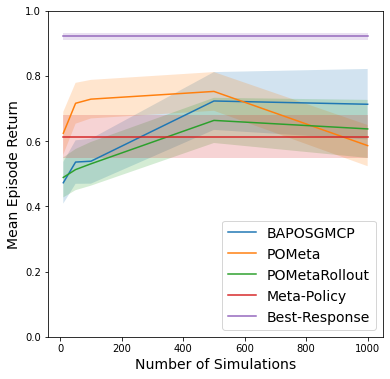

In [80]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [66]:
belief_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["POMeta"]))
        | ((exp_df["alg_id"].isin(["baposgmcp", "POMetaRollout"])) & (exp_df["truncated"] == True))
    )
    
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
Ungrouped size = 45
Grouped size = 15


In [77]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    # "title": "Num. Sims." 
})

POMeta
POMetaRollout
baposgmcp


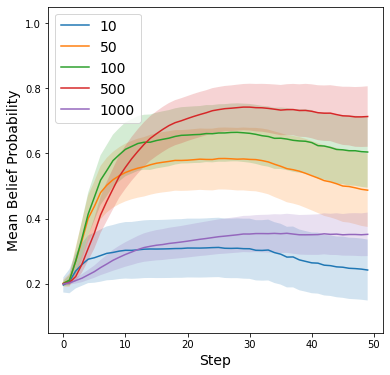

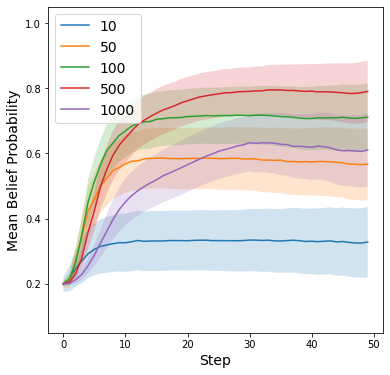

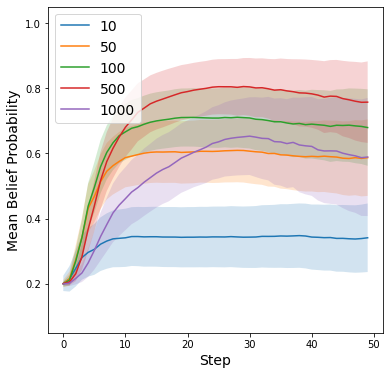

In [78]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Probability",
    "ylim": (0.05, 1.05),
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="bayes_accuracy",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp


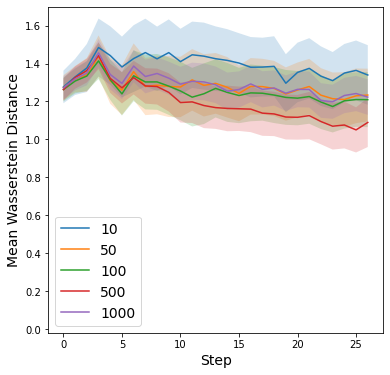

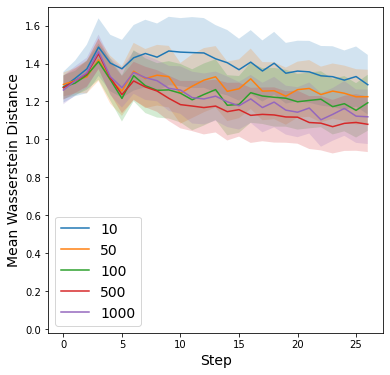

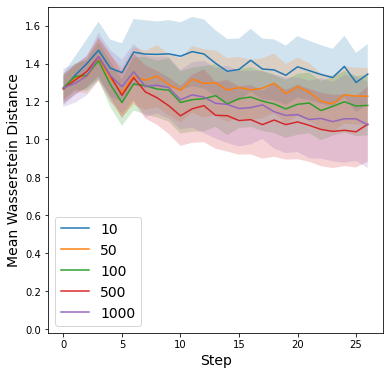

In [79]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Wasserstein Distance",
    "ylim": (-0.02, 1.7),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "lower left",
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="action_dist_distance",
        step_limit=27,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"action_dist_{alg_id}.png"))
    
del plot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [48]:
times_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', None]))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random", "POMetaRollout", "POMeta"]))
]

print(times_df["truncated"].unique())

times_group_keys = ["alg_id", "truncated", "num_sims"]
times_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in times_group_keys:
    if k in times_agg_dict:
        times_agg_dict.pop(k)
    
times_agg_dict["policy_id"] = pd.NamedAgg(column="policy_id", aggfunc="first")
        
gb = times_df.groupby(times_group_keys)
gb_agg = gb.agg(**times_agg_dict)
times_gb_df = gb_agg.reset_index()

times_gb_df.sort_values(by=["alg_id", "truncated", "num_sims"], inplace=True)

print("Ungrouped size =", len(times_df))
print("Grouped size =", len(times_gb_df))

times_alg_ids = times_gb_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = times_gb_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)
    
    
# based on output of policy IDs (since we group IDS)
time_pi_label_map = {
    # "baposgmcp_uniform": r"BAPOSGMCP",
    "baposgmcp_softmax": r"BAPOSGMCP",
    # "baposgmcp_greedy": r"BAPOSGMCP",
    # "baposgmcp_random": "BAPOSGMCP Random",
    # "baposgmcp_fixed": "BAPOSGMCP Fixed",
    "POMeta": "POMeta", 
    "POMetaRollout": "POMetaRollout", 
    # "metabaseline": "Meta-Policy",
}

sim_policies = [
    # "baposgmcp_uniform",
    "baposgmcp_softmax",
    # "baposgmcp_greedy",
    # "baposgmcp_random",
    # "baposgmcp_fixed",
    "POMetaRollout", 
]

[ True]
Ungrouped size = 70
Grouped size = 20
Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed

Policy IDs
----------
POMetaRollout_greedy_numsims10
POMetaRollout_greedy_numsims100
POMetaRollout_greedy_numsims1000
POMetaRollout_greedy_numsims50
POMetaRollout_greedy_numsims500
POMeta_greedy_numsims10
POMeta_greedy_numsims100
POMeta_greedy_numsims1000
POMeta_greedy_numsims50
POMeta_greedy_numsims500
baposgmcp_fixed_pispseed0-v0_numsims10
baposgmcp_fixed_pispseed0-v0_numsims100
baposgmcp_fixed_pispseed0-v0_numsims1000
baposgmcp_fixed_pispseed0-v0_numsims50
baposgmcp_fixed_pispseed0-v0_numsims500
baposgmcp_greedy_numsims10
baposgmcp_greedy_numsims100
baposgmcp_greedy_numsims1000
baposgmcp_greedy_numsims50
baposgmcp_greedy_numsims500


POMetaRollout
baposgmcp
baposgmcp_fixed


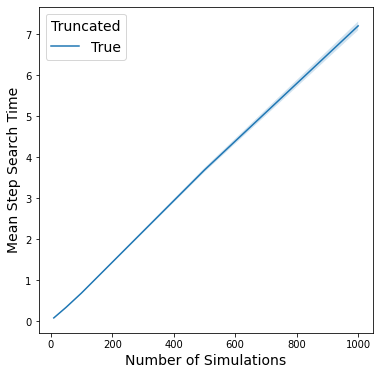

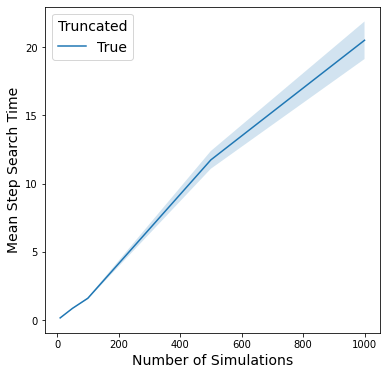

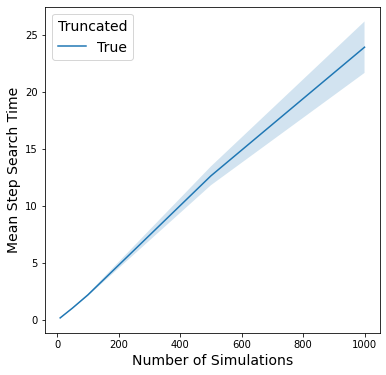

In [50]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Step Search Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_time_mean",
        y_err_key="search_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_search_time_{alg_id}.png"))
    
del time_plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed


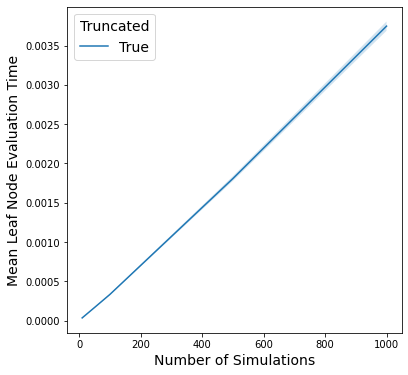

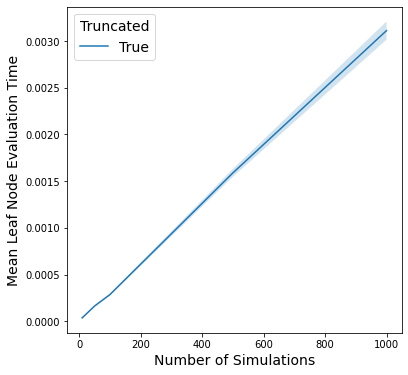

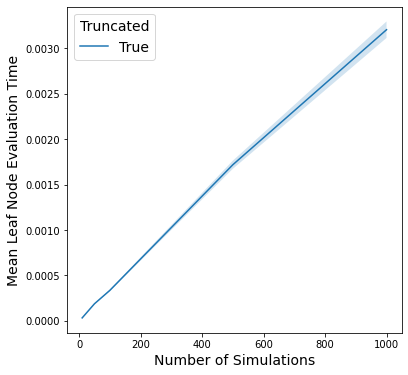

In [51]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Leaf Node Evaluation Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="evaluation_time_mean",
        y_err_key="evaluation_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_eval_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed


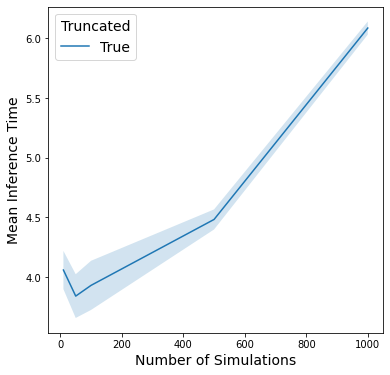

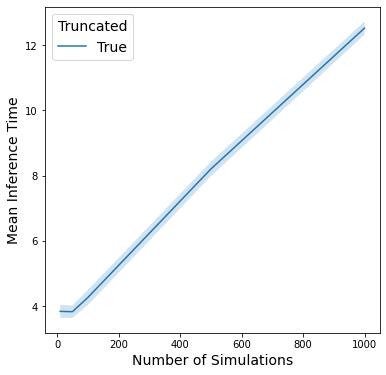

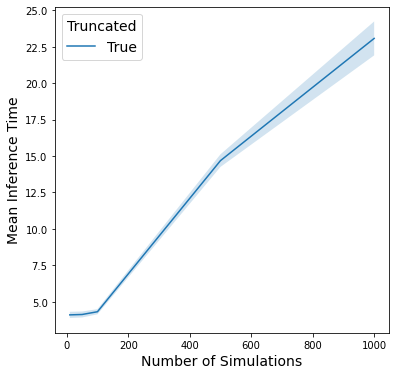

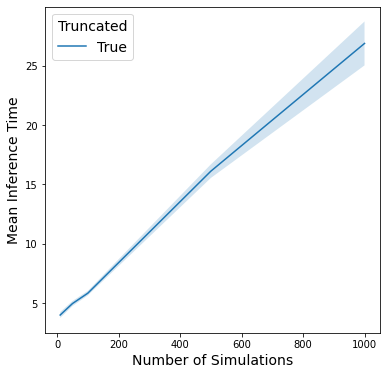

In [52]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Inference Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="inference_time_mean",
        y_err_key="inference_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_inference_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed


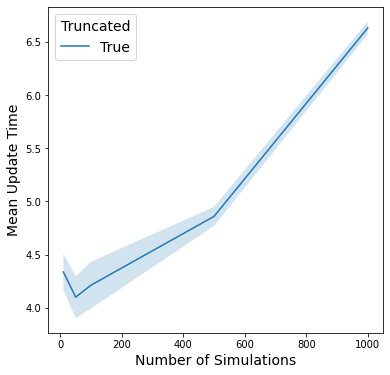

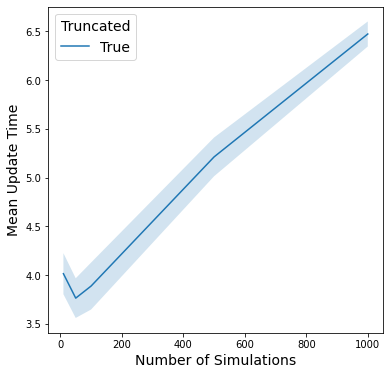

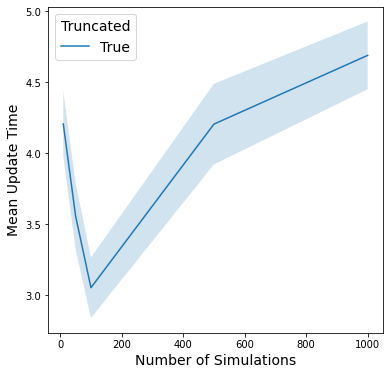

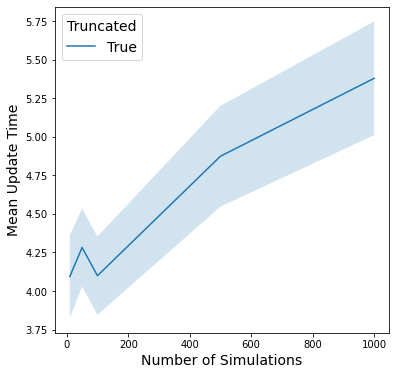

In [53]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Update Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="update_time_mean",
        y_err_key="update_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_update_time_{alg_id}.png"))
    
del time_plot_kwargs

POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed


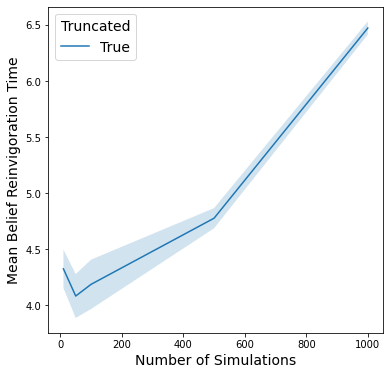

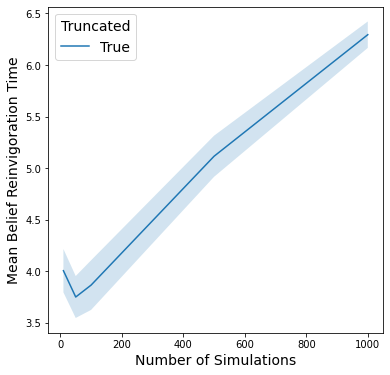

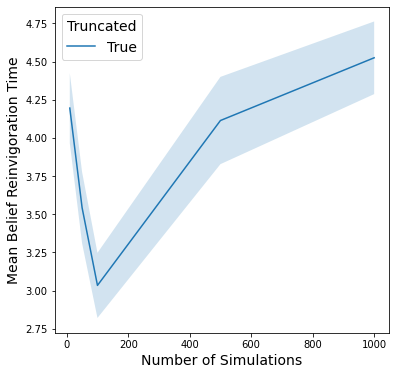

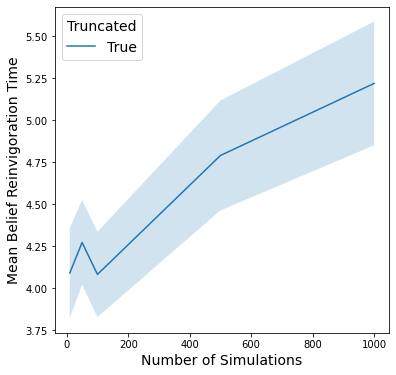

In [54]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Reinvigoration Time",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="reinvigoration_time_mean",
        y_err_key="reinvigoration_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_reinvigoration_time_{alg_id}.png"))
    
del time_plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed


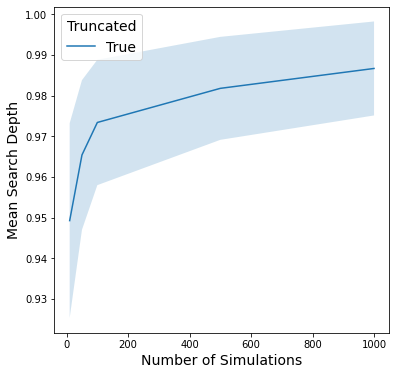

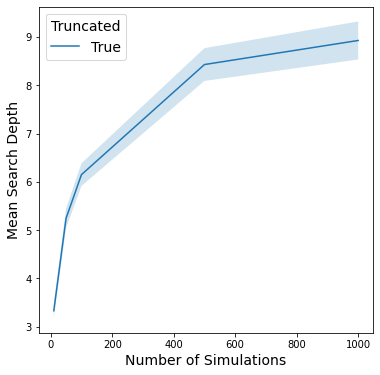

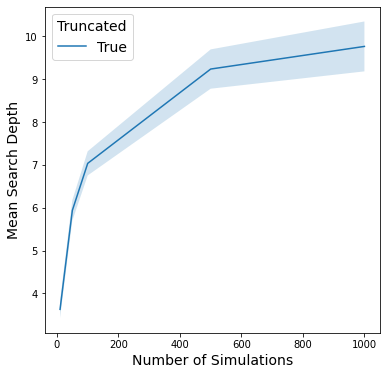

In [55]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Search Depth",
    # "ylim": (0, 75),
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in times_alg_ids:
    if alg_id == "POMeta":
        continue
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        times_gb_df[times_gb_df["alg_id"] == alg_id],
        y_key="search_depth_mean",
        y_err_key="search_depth_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"truncated_search_depth_{alg_id}.png"))
    
del time_plot_kwargs